In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)

local


In [2]:
mine = kgs.dill_load(kgs.code_dir + '../res/mine.pickle')

In [3]:
expanded = []  # list[SolutionCollectionSquare], each with N_solutions=8
transformations = [
    (0.0,        False),  # Identity
    (np.pi/2,    False),  # 90° rotation
    (np.pi,      False),  # 180° rotation
    (3*np.pi/2,  False),  # 270° rotation
    (0.0,        True),   # Mirror (y -> -y)
    (np.pi/2,    True),   # Mirror + 90° rotation
    (np.pi,      True),   # Mirror + 180° rotation
    (3*np.pi/2,  True),   # Mirror + 270° rotation
    ]
for s in mine[0]:
    # s is a SolutionCollectionSquare with 1 individual. expand it to 8 with the symmetries
    assert isinstance(s, kgs.SolutionCollectionSquare)
    assert s.xyt.shape[0] == 1, f"Expected 1 solution row, got {s.xyt.shape[0]}"
    base_xyt = s.xyt[0]  # (N_trees, 3) on GPU
    base_h = s.h[0]      # (3,) on GPU: [size, x_offset, y_offset]
    n_trees = base_xyt.shape[0]
    cx = base_h[1]
    cy = base_h[2]
    x0 = base_xyt[:, 0] - cx
    y0 = base_xyt[:, 1] - cy
    t0 = base_xyt[:, 2]
    xyt8 = cp.empty((8, n_trees, 3), dtype=base_xyt.dtype)
    for k, (rot_angle, do_mirror) in enumerate(transformations):
        x = x0
        y = y0
        t = t0
        if do_mirror:
            y = -y
            t = cp.pi - t
        if rot_angle != 0.0:
            c = np.cos(rot_angle)
            s_ = np.sin(rot_angle)
            xr = x * c - y * s_
            yr = x * s_ + y * c
            tr = t + rot_angle
        else:
            xr = x
            yr = y
            tr = t
        tr = cp.remainder(tr, 2 * np.pi)  # keep in [0, 2π)
        xyt8[k, :, 0] = xr + cx
        xyt8[k, :, 1] = yr + cy
        xyt8[k, :, 2] = tr
    h8 = cp.tile(base_h[cp.newaxis, :], (8, 1))
    expanded.append(kgs.SolutionCollectionSquare(xyt=xyt8, h=h8, use_fixed_h=s.use_fixed_h, periodic=False))

In [4]:
type(s)

kaggle_support.SolutionCollectionSquare

0it [00:00, ?it/s]

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin


38it [00:00, 110.02it/s]

ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 8.928 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.125 ms
ptxas info    : Compiling entry function 'auction_kernel' for 'sm_89'
ptxas info    : Function properties for auction_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 35 registers, used 0 barriers, 412 bytes cmem[0]
ptxas info    : Compile time = 6.863 ms
ptxas info    : Compiling entry function 'hun

200it [00:06, 29.22it/s]


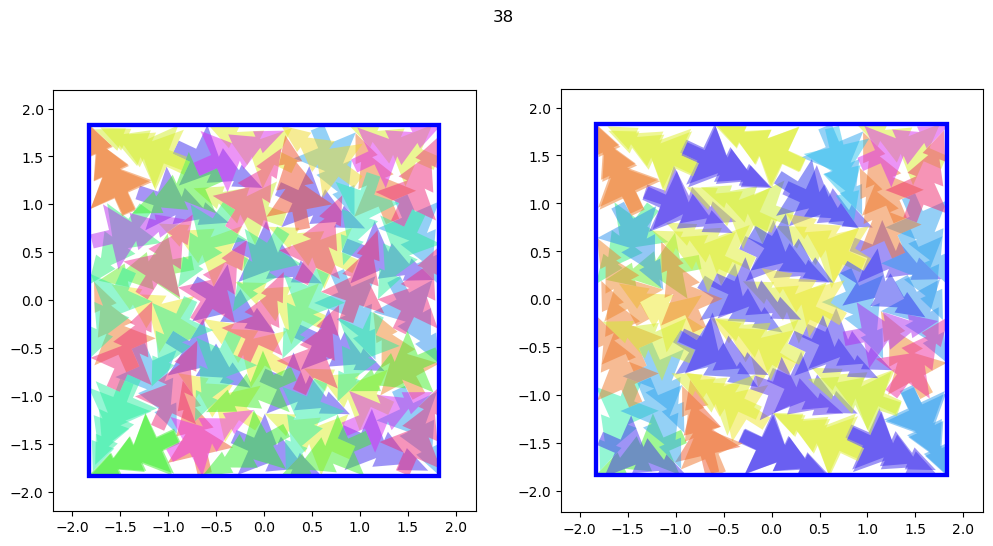

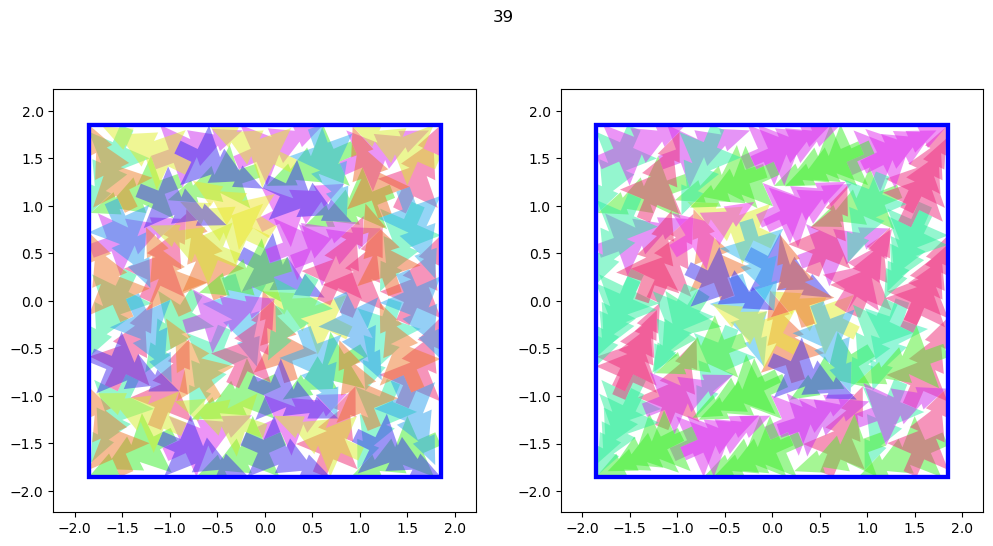

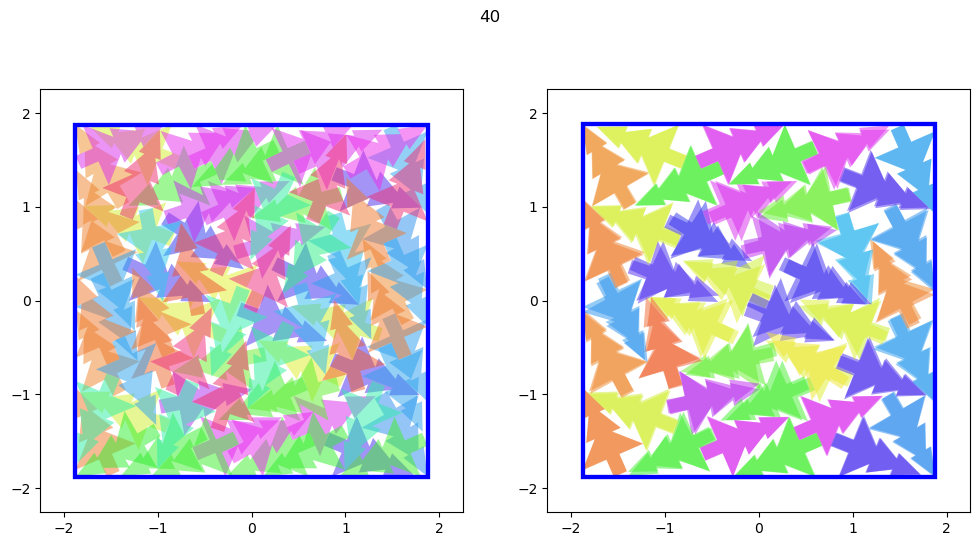

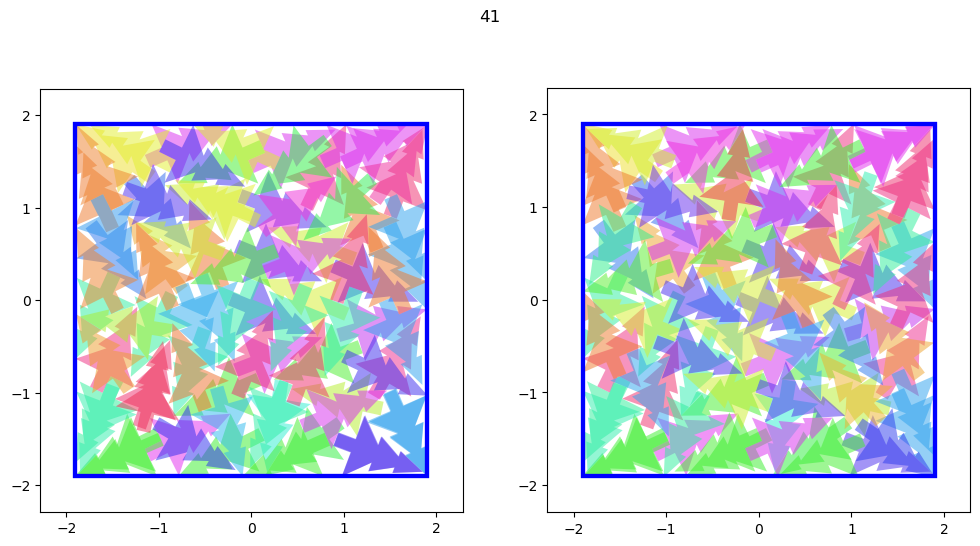

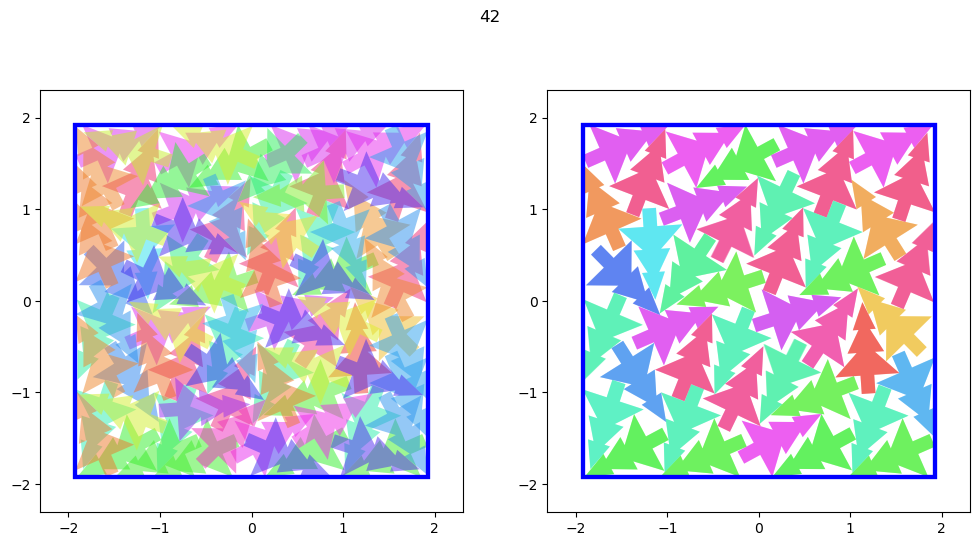

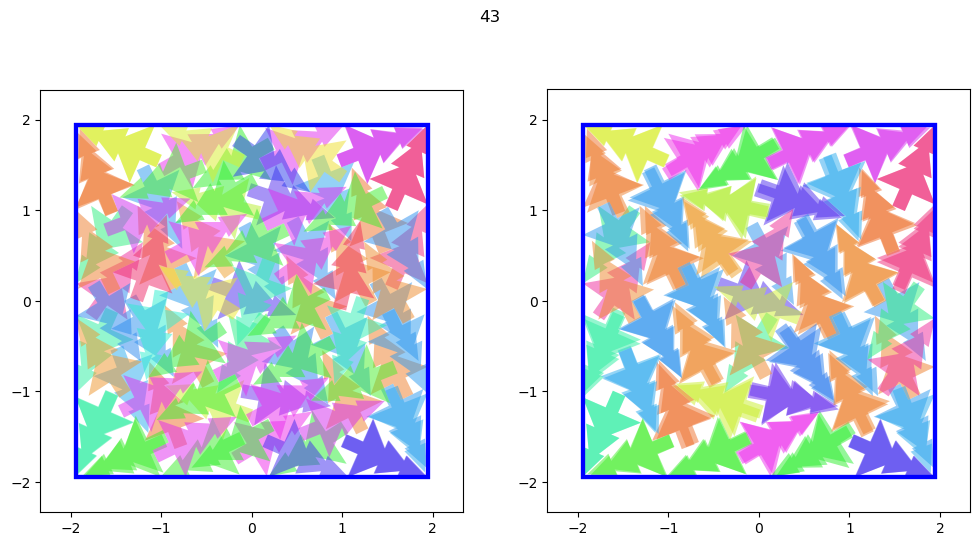

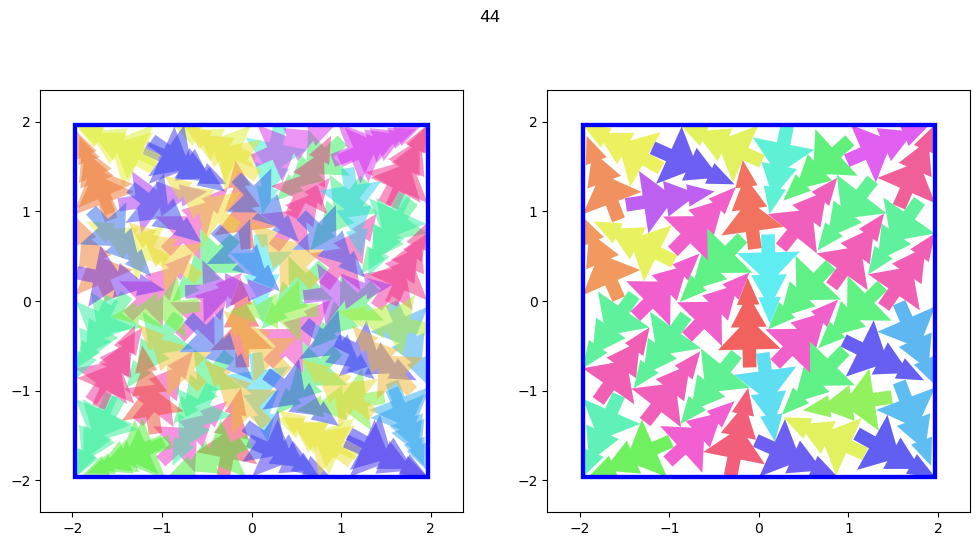

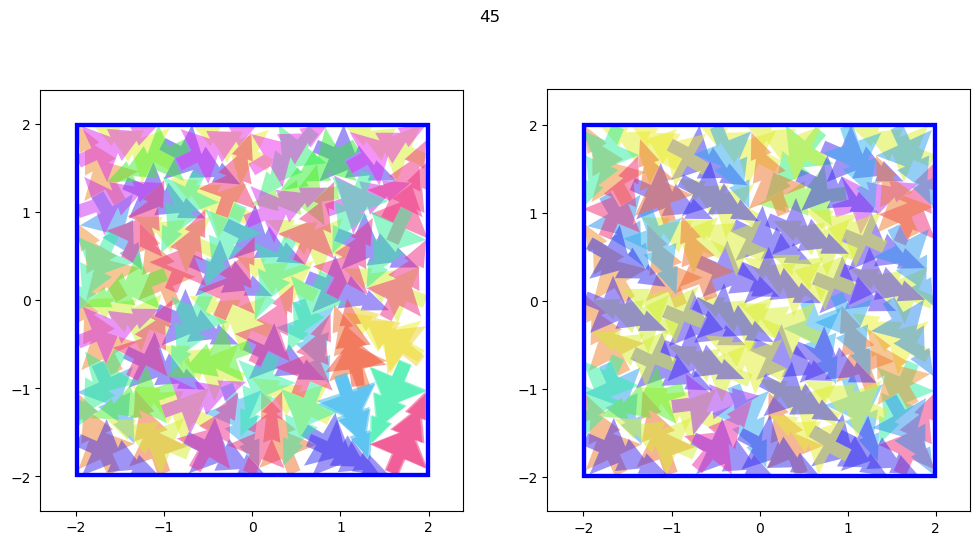

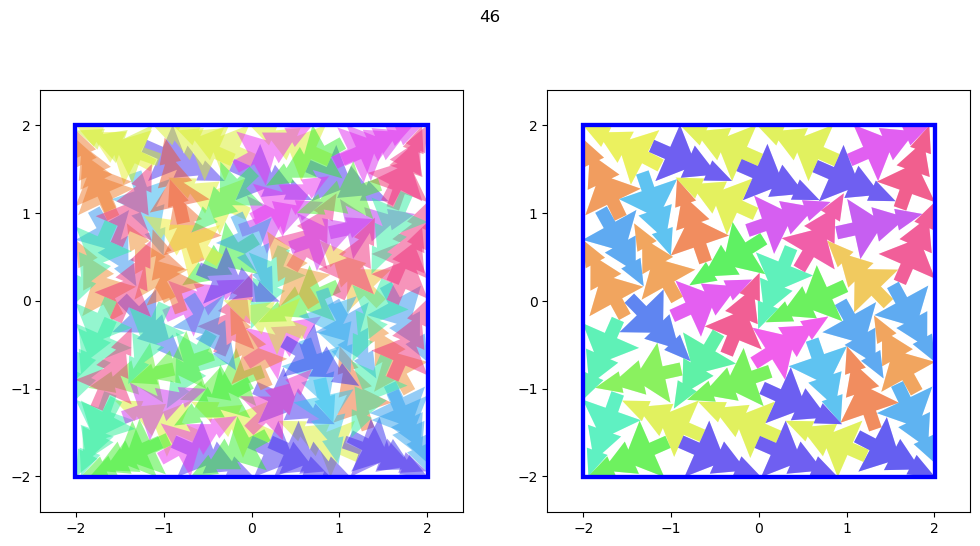

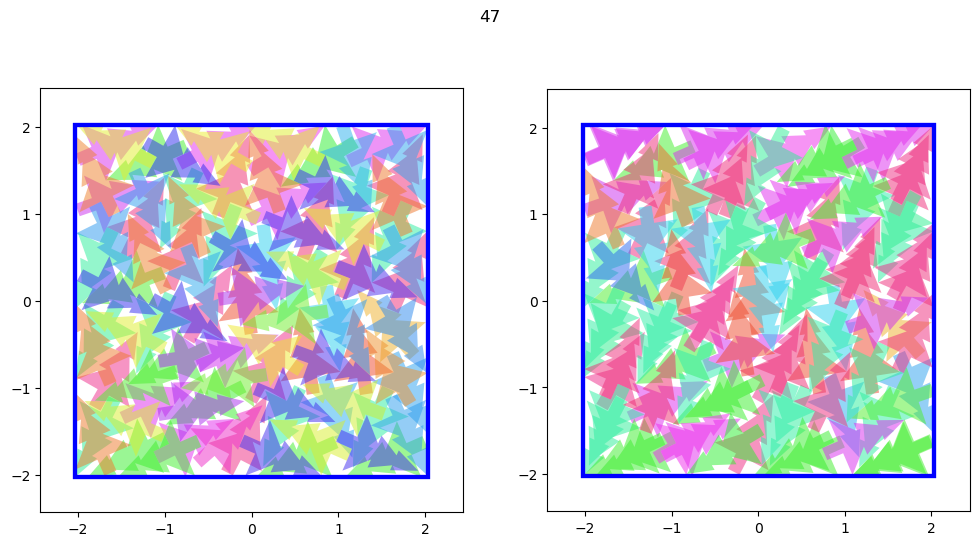

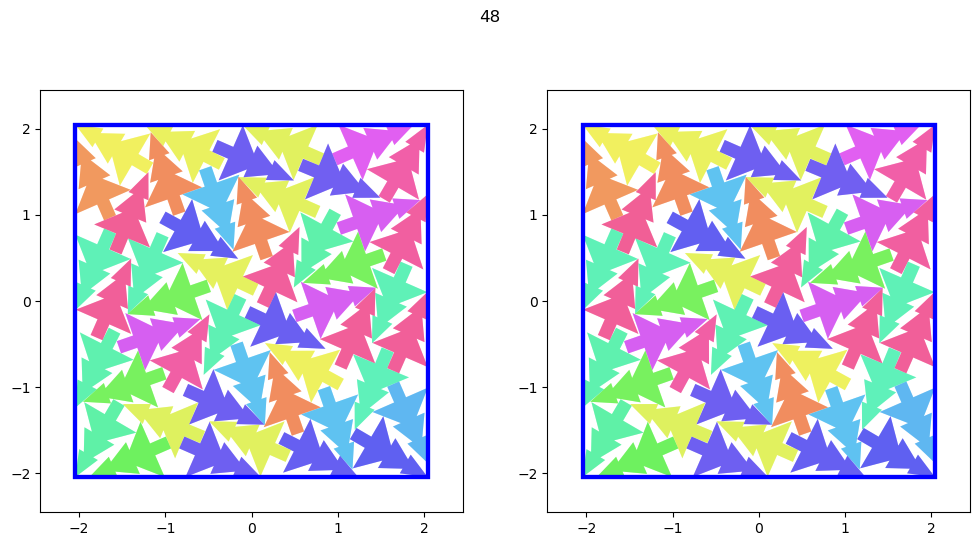

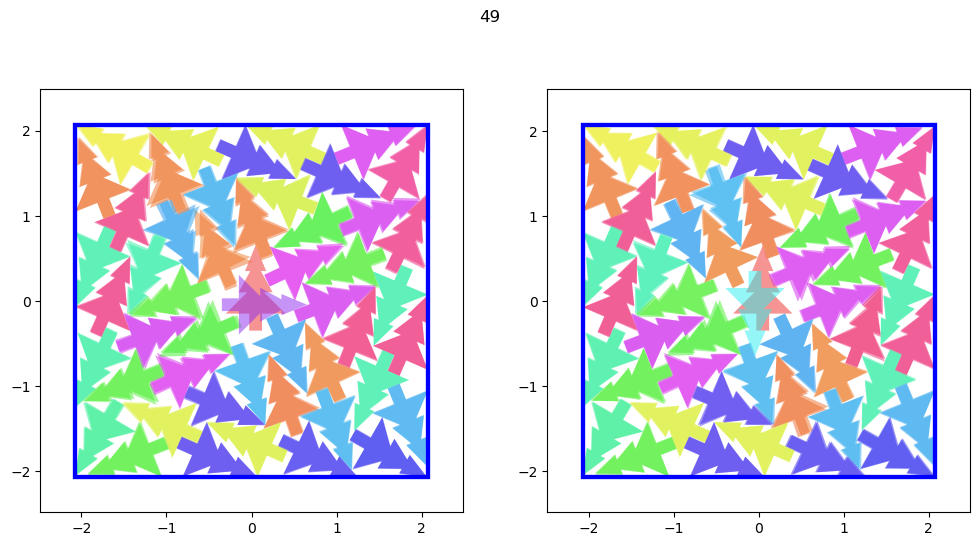

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
matrices = []
for i,e in tqdm(enumerate(expanded)):
    matrix = kgs.compute_genetic_diversity_matrix(e.xyt, e.xyt, transform=False)
    matrix /= e.N_trees
    matrices.append(matrix.get())
    # try:
    #     assert np.all( (matrix.get()<0.005) | (matrix.get()>0.05))
    # except:
    #     import matplotlib.pyplot as plt
    #     labels = [
    #         "Identity",
    #         "Rotate +90°",
    #         "Rotate 180°",
    #         "Rotate 270°",
    #         "Mirror across x-axis",
    #         "Mirror across line y=x",
    #         "Mirror across y-axis",
    #         "Mirror across line y=-x",
    #     ]
    #     fig, ax = plt.subplots(1,2,figsize=(12,6))
    #     im = ax[0].imshow(np.log(matrix.get())/np.log(10))
    #     fig.colorbar(im, ax=ax[0])
    #     ax[0].set_yticks(range(len(labels)))
    #     ax[0].set_yticklabels(labels)
    #     # Focus the colormap on the "bad" band: 0.01 .. 0.1  (log10 -> -2 .. -1)
    #     im.set_clim(-3.0, 0.)
    #     plt.suptitle(e.N_trees)
    #     pack_vis_sol.pack_vis_sol(e, ax=ax[1])
    if i+1 in np.arange(38, 50, 1):
        labels = [
            "Identity",
            "Rotate +90°",
            "Rotate 180°",
            "Rotate 270°",
            "Mirror across x-axis",
            "Mirror across line y=x",
            "Mirror across y-axis",
            "Mirror across line y=-x",
        ]
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        #im = ax[0].imshow(np.log(matrix.get())/np.log(10))
        #fig.colorbar(im, ax=ax[0])
        #ax[0].set_yticks(range(len(labels)))
        #ax[0].set_yticklabels(labels)
        # Focus the colormap on the "bad" band: 0.01 .. 0.1  (log10 -> -2 .. -1)
        #im.set_clim(-3.0, 0.)
        plt.suptitle(e.N_trees)
        pack_vis_sol.pack_vis_sol(e, ax=ax[1], alpha=0.5)
        ee = copy.deepcopy(e)
        ee.rotate(cp.array([np.pi], dtype=kgs.dtype_cp))
        pack_vis_sol.pack_vis_sol(ee, ax=ax[1], alpha=0.5)
        pack_vis_sol.pack_vis_sol(e, ax=ax[0], alpha=0.5)
        ee = copy.deepcopy(e)
        ee.rotate(cp.array([np.pi/2], dtype=kgs.dtype_cp))
        pack_vis_sol.pack_vis_sol(ee, ax=ax[0], alpha=0.5)

In [6]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display

# Symmetry criterion: matrix entry < 0.05 indicates invariance under that transform
THRESH = 0.05

# Indices into the 8-way transform list (see `transformations` in cell 3)
sym_transforms = {
    "Identity": 0,
    "Rotate +90°": 1,
    "Rotate 180°": 2,
    "Rotate 270°": 3,
    "Mirror x-axis": 4,
    "Mirror y=x": 5,
    "Mirror y-axis": 6,
    "Mirror y=-x": 7,
}

n = min(200, len(expanded))
if len(expanded) < 200:
    print(f"Warning: only {len(expanded)} expanded solutions available; showing {n}.")

rows = []
for i in range(n):
    e = expanded[i]
    if "matrices" in globals() and i < len(matrices):
        m = np.asarray(matrices[i])
    else:
        m = kgs.compute_genetic_diversity_matrix(e.xyt, e.xyt, transform=False)
        m = (m / e.N_trees).get()
    row = {"Solution": i+1}
    for name, idx in sym_transforms.items():
        row[name] = np.round(1000*(1/m[0,idx])).astype(int)#bool(m[0, idx] < THRESH)
    rows.append(row)

df_bool = pd.DataFrame(rows).set_index("Solution")
totals = df_bool.sum(axis=0).to_frame().T
totals.index = ["TOTAL"]
df_full = pd.concat([df_bool, totals])

def _fmt(v):
    if isinstance(v, (bool, np.bool_)):
        return "✓" if v else ""
    return int(v) if isinstance(v, (int, np.integer)) else v

df_show = df_full.applymap(_fmt)

# Force a non-abbreviated rendering (200 rows)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 0)
pd.set_option("display.max_colwidth", None)

display(HTML(df_show.to_html()))

/tmp/ipykernel_8195/3720345547.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_show = df_full.applymap(_fmt)


,Identity,Rotate +90°,Rotate 180°,Rotate 270°,Mirror x-axis,Mirror y=x,Mirror y-axis,Mirror y=-x
1,1398101376,637,318,637,637,133009168,637,318
2,8388608000,621,166611328,621,1045,1163,1045,1163
3,1797558912,610,468,610,1182,536,521,1112
4,2796202752,632,908659648,632,1183,1040,1183,1040
5,1906501760,2777,1472,2777,956,940,951,944
6,1935832448,904,726,904,1013,2119,848,718
7,3262236416,1011,1233,1011,1053,1733,1054,1556
8,2796202752,1897,68339584,1897,952,982,952,982
9,2359296000,790,595,790,832,2087,811,591
10,3226387712,896,802,896,798,905,4131,866
